In [1]:
# Register the catalyst magic
#%load_ext catalyst

# Setup matplotlib to display graphs inline in this Notebook
%matplotlib inline


[2018-01-04 17:29:41.653081] INFO: run_algo: running algo in backtest mode
[2018-01-04 17:29:42.296163] INFO: exchange_algorithm: initialized trading algorithm in backtest mode


bcc_usd Not found
bcc_usd Not found
bcc_usd Not found
bcc_usd Not found
bcc_usd Not found
bcc_usd Not found
bcc_usd Not found


[2018-01-04 17:29:44.433337] INFO: Performance: Simulated 185 trading days out of 185.
[2018-01-04 17:29:44.435881] INFO: Performance: first open: 2017-05-30 00:00:00+00:00
[2018-01-04 17:29:44.437956] INFO: Performance: last close: 2017-11-30 23:59:00+00:00


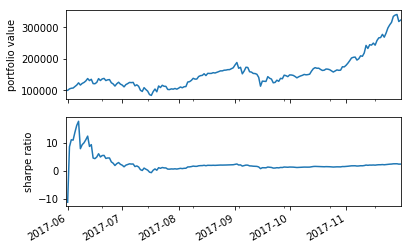

In [3]:
#%%catalyst --start 2017-5-30 --end 2017-11-30 --capital-base 100000 -x bitfinex -c usd

from __future__ import division
import os
import pytz
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from catalyst.api import record, symbol, symbols, order_target_percent
from catalyst.utils.run_algo import run_algorithm


def initialize(context):
   context.coins = coins = [ 
         #'ada',
         'bch', 'btg', 'eos',
         'eth', 'ltc', 'ppt',
         #'xlm',
         'xrp', 'bcc', 'btc', 'dsh',
         'etc', 'iot', 'neo', 
         #'xem',
         'xmr', 'zec',]
   
   ### read vol and cap data
   
   context.volcapdata = pd.DataFrame.from_csv( 'voldata.csv', index_col = 1 )
    
   context.window = 7
   # Set the number of days between each portfolio rebalancing
   context.rebalance_period = 7                   
   context.i = 0
   context.base_currency = 'usd'
   context.exchange = context.exchanges.values()[0].name.lower()
    
def handle_data(context, data):
   # Only rebalance at the beggining of the algorithm execution and 
   # every multiple of the rebalance period
   if context.i%context.rebalance_period == 0:
       
       v = context.volcapdata[context.volcapdata['coin'].isin(context.coins)]
       weights = v[ v.index < data.current_dt ].groupby('coin').tail(7).groupby('coin').mean()['volume'].nlargest(10)      
       
       #weights = volume.mean().nlargest(10) 
       weights = weights/weights.sum()
       
              #order optimal weights for each asset
       for coin in weights.index:
           assetname = coin+ "_" + context.base_currency
           try:
               asset = symbol(assetname)
               if data.can_trade(asset):
                   order_target_percent(asset, weights[coin])
           except:
               print (assetname + ' Not found') 

       record(weights=weights)
   context.i += 1
   
       
def analyze(context=None, results=None):
   ax1 = plt.subplot(211)
   results.portfolio_value.plot(ax=ax1)
   ax1.set_ylabel('portfolio value')
   ax2 = plt.subplot(212, sharex=ax1)
   results.sharpe.plot(ax=ax2)
   ax2.set_ylabel('sharpe ratio')
   plt.show()    
    
   # Form DataFrame with selected data
   data = results[['weights']]
   
   # Save results in CSV file
   #filename = os.path.splitext(os.path.basename(__file__))[0]
   filename = 'vol_weighted_strat_results'
   data.to_csv(filename + '.csv')
    
    
start = datetime(2017, 5, 30, 0, 0, 0, 0, pytz.utc)
end = datetime(2017, 11, 30, 0, 0, 0, 0, pytz.utc) 
results = run_algorithm(initialize=initialize,
                        handle_data=handle_data,
                        analyze=analyze,
                        start=start,
                        end=end,
                        exchange_name='bitfinex',
                        capital_base=100000, )